# To experiment with some deep learning models on the time series data given

In [98]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader, TensorDataset

In [99]:
df = pd.read_csv("./data/processed/Mastercard_stock_history_processed.csv")
df.head()
df = df[["Open", "Volume",  "lag_1","lag_2","MA","M_STD", "month", "day","quarter","Close"]]

In [100]:
train_df = df[:-100]
test_df = df[-100:]

In [101]:
train_df_torch = torch.from_numpy(train_df.to_numpy()).type(torch.float32)
test_df_torch = torch.from_numpy(test_df.to_numpy()).type(torch.float32)

X_train, y_train = train_df_torch[:, :-1], train_df_torch[:, -1].reshape(-1, 1)
X_test, y_test= test_df_torch[:, :-1], test_df_torch[:, -1].reshape(-1, 1)


In [118]:
class TimeSeriesLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout_rate):
        super().__init__()
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # Define the LSTM layer
        # self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        
        # Define the fully connected layer
        self.input = nn.Sequential(
            nn.Linear(input_size, 256),
            nn.Sigmoid(),
        )
        self.mlp_block1 = nn.Sequential(
            nn.Linear(256, 256),
            nn.Tanh(),
            nn.Dropout(dropout_rate),
            nn.Linear(256, 512),
            nn.ELU(alpha=0.5),
            nn.Linear(512, 512),
            nn.LeakyReLU(negative_slope = 0.15),
        )

      
        self.output_lyr = nn.Linear(512, output_size)
        
    
    def forward(self, x):
        a0 = self.input(x)
        a1 = self.mlp_block1(a0)
        a2 = self.output_lyr(a1)
        return a2


In [119]:
def initialize_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight)
        nn.init.zeros_(m.bias)
    elif isinstance(m, nn.LSTM):
        for name, param in m.named_parameters():
            if "bias" in name:
                nn.init.zeros_(param)
            elif "weight" in name:
                nn.init.orthogonal_(param)

In [120]:
model = TimeSeriesLSTM(
    input_size=9,
    num_layers=5,
    hidden_size=128,
    output_size=1,
    dropout_rate=0.2
)

model.apply(initialize_weights)
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
# scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[16, 50, 80], gamma=0.0001)
# loader = load_data("data/processed/mastercard_stock_history_processed.csv", batch_size=8)
loader = DataLoader(TensorDataset(X_train, y_train), shuffle = False, batch_size = 8)
train_rmse_lst = []
test_rmse_lst = []
 
n_epochs = 100
for epoch in range(n_epochs):
    model.train()
    for X_batch, y_batch in loader:
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # scheduler.step()
    # Validation
    if epoch % 1 != 0:
        continue
    model.eval()
    with torch.no_grad():
        y_pred = model(X_train)
        train_rmse = np.sqrt(loss_fn(y_pred, y_train))
        # train_rmse = loss_fn(y_pred, y_train)
        y_pred = model(X_test)
        test_rmse = np.sqrt(loss_fn(y_pred, y_test))

        train_rmse_lst.append(train_rmse)
        test_rmse_lst.append(test_rmse)
        # test_rmse = loss_fn(y_pred, y_test)
    print("Epoch %d: train RMSE %.4f, test RMSE %.4f" % (epoch, train_rmse, test_rmse))

Epoch 0: train RMSE 272.7282, test RMSE 16.9337
Epoch 1: train RMSE 281.5384, test RMSE 15.3879
Epoch 2: train RMSE 260.0919, test RMSE 19.6128
Epoch 3: train RMSE 242.3990, test RMSE 16.6551
Epoch 4: train RMSE 205.5942, test RMSE 18.0892
Epoch 5: train RMSE 181.3243, test RMSE 18.0918
Epoch 6: train RMSE 167.3308, test RMSE 15.2321
Epoch 7: train RMSE 151.9219, test RMSE 14.1904
Epoch 8: train RMSE 141.2832, test RMSE 18.9417
Epoch 9: train RMSE 112.0865, test RMSE 22.4318
Epoch 10: train RMSE 101.9815, test RMSE 18.3895
Epoch 11: train RMSE 75.4730, test RMSE 19.6466
Epoch 12: train RMSE 75.0305, test RMSE 14.6639
Epoch 13: train RMSE 63.5481, test RMSE 14.9239
Epoch 14: train RMSE 55.0346, test RMSE 16.3945
Epoch 15: train RMSE 50.2058, test RMSE 15.3218
Epoch 16: train RMSE 47.8718, test RMSE 14.9777
Epoch 17: train RMSE 43.2775, test RMSE 15.8125
Epoch 18: train RMSE 53.1902, test RMSE 15.5545
Epoch 19: train RMSE 41.5283, test RMSE 14.3307
Epoch 20: train RMSE 41.8325, test RMSE

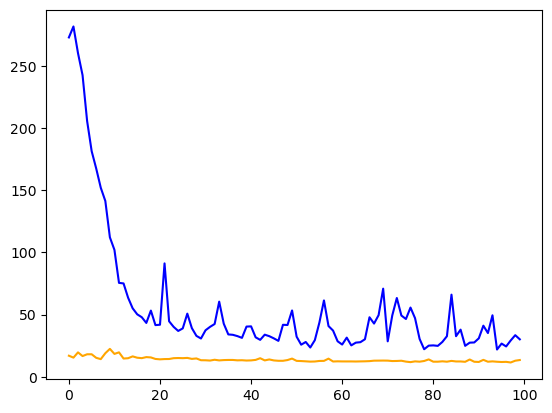

In [121]:
plt.plot(train_rmse_lst, color = "blue")
plt.plot(test_rmse_lst, color = "orange")
plt.show()